In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import optimizer
import warnings
import os
from optimizer import Adam, AdamWithDiff, AdaGradWithDiff, AdaGrad
warnings.filterwarnings('ignore')

In [ ]:
# Function to load CIFAR10 dataset
def load_data(batch_size):
    transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    trainset = torchvision.datasets.CIFAR10(root='./src/data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./src/data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)
    
    print("Number of training examples: ", len(trainset))
    print("Number of test examples: ", len(testset))
    return trainloader, testloader

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        model.eval()
        val_loss, val_acc = validate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to validate the model
def validate_model(model, testloader, criterion, device):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = validation_loss / len(testloader)
    val_acc = 100.0 * correct / total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    return val_loss, val_acc

# Function to plot loss and accuracy
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, plot_name = None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

def df_model(with_batch_norm, device):
    if with_batch_norm:
        model = models.resnet34(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model
    else:
        model = models.resnet34(weights=None)
        model = remove_batch_norm_layers(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model # Implement the model without batch normalization

def remove_batch_norm_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.Identity())
        else:
            remove_batch_norm_layers(module)
    return model


# Main function to run the training and validation
def main(model, optimizer, batch_size, num_epochs, experiment_name, save_path, plot = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainloader, testloader = load_data(batch_size)

    criterion = nn.CrossEntropyLoss()
    

    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader)

    # save the train-val loss and accuracy
    os.makedirs(save_path, exist_ok=True)
    np.save(save_path + experiment_name + '_train_losses.npy', train_losses)
    np.save(save_path + experiment_name + '_train_accuracies.npy', train_accuracies)
    np.save(save_path + experiment_name + '_val_losses.npy', val_losses)
    np.save(save_path + experiment_name + '_val_accuracies.npy', val_accuracies)


    if plot:
        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, experiment_name)

    return train_losses, train_accuracies, val_losses, val_accuracies

if __name__ == '__main__':

    #adam with batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAM_custom_with_batch_norm', save_path='./results/')

    #adam without batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAM_custom_without_batch_norm', save_path='./results/')

    #adagrad with batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGrad_custom_with_batch_norm', save_path='./results/')

    #adagrad without batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGrad_custom_without_batch_norm', save_path='./results/')

    #AdamWithDiff with batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAMwithdiff_with_batch_norm', save_path='./results/')

    #AdamWithDiff without batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAMwithdiff_without_batch_norm', save_path='./results/')

    #AdaGradWithDiff with batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGradWithDiff_with_batch_norm', save_path='./results/')

    #AdaGradWithDiff without batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGradWithDiff_without_batch_norm', save_path='./results/')

    

### Ploting the result

In [5]:
COLOR_adadiff = 'orange'
COLOR_adam = 'blue'
COLOR_ada = 'red'
COLOR_adamdiff = 'magenta'

#### Training loss

In [6]:
train_loss_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_train_losses.npy")
train_loss_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_train_losses.npy")
train_loss_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_train_losses.npy")
train_loss_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_train_losses.npy")

train_loss_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_train_losses.npy")
train_loss_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_train_losses.npy")
train_loss_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_train_losses.npy")
train_loss_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_train_losses.npy")

In [7]:
#small hack for big values
train_loss_ada_w_bn[0] = train_loss_ada_w_bn[1]
train_loss_adagrad_w_diff_wo_bn[0] = train_loss_adagrad_w_diff_wo_bn[1]

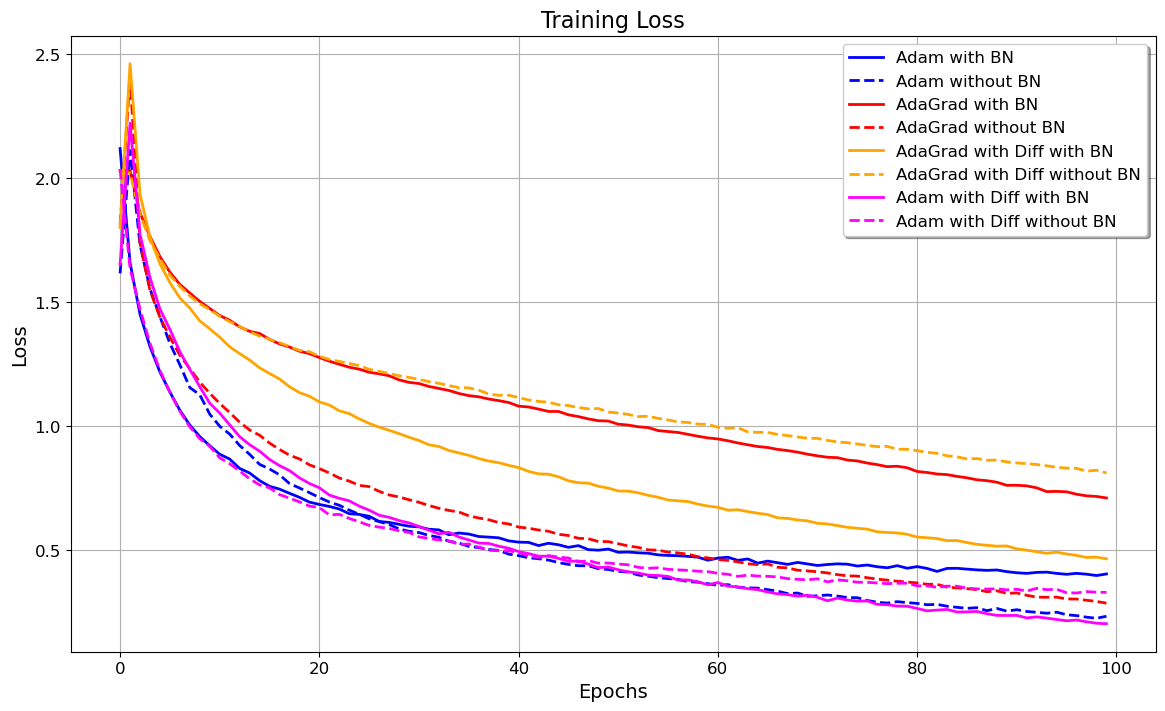

In [25]:
LINEWIDTH = 2

plt.figure(figsize=(14, 8))

# Plotting with improved styles
plt.plot(train_loss_adam_w_bn, label='Adam with BN', color=COLOR_adam, linewidth=LINEWIDTH)
plt.plot(train_loss_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_loss_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada, linewidth=LINEWIDTH)
plt.plot(train_loss_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_loss_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff, linewidth=LINEWIDTH)
plt.plot(train_loss_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_loss_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff, linewidth=LINEWIDTH)
plt.plot(train_loss_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed', linewidth=LINEWIDTH)

# Adding grid, labels, and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss', fontsize=16)
plt.grid(True)

# Improving legend
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)

# Adding tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./figures/train-losses.png', bbox_inches='tight')



In [9]:
# Training loss plot with different optimizers bar plot only 
plt.figure(figsize=(14, 8))


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

<Figure size 1400x800 with 0 Axes>

#### Training accuracies


In [10]:
#Training accuracies

train_acc_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_train_accuracies.npy")
train_acc_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_train_accuracies.npy")
train_acc_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_train_accuracies.npy")
train_acc_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_train_accuracies.npy")

train_acc_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_train_accuracies.npy")
train_acc_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_train_accuracies.npy")
train_acc_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_train_accuracies.npy")
train_acc_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_train_accuracies.npy")


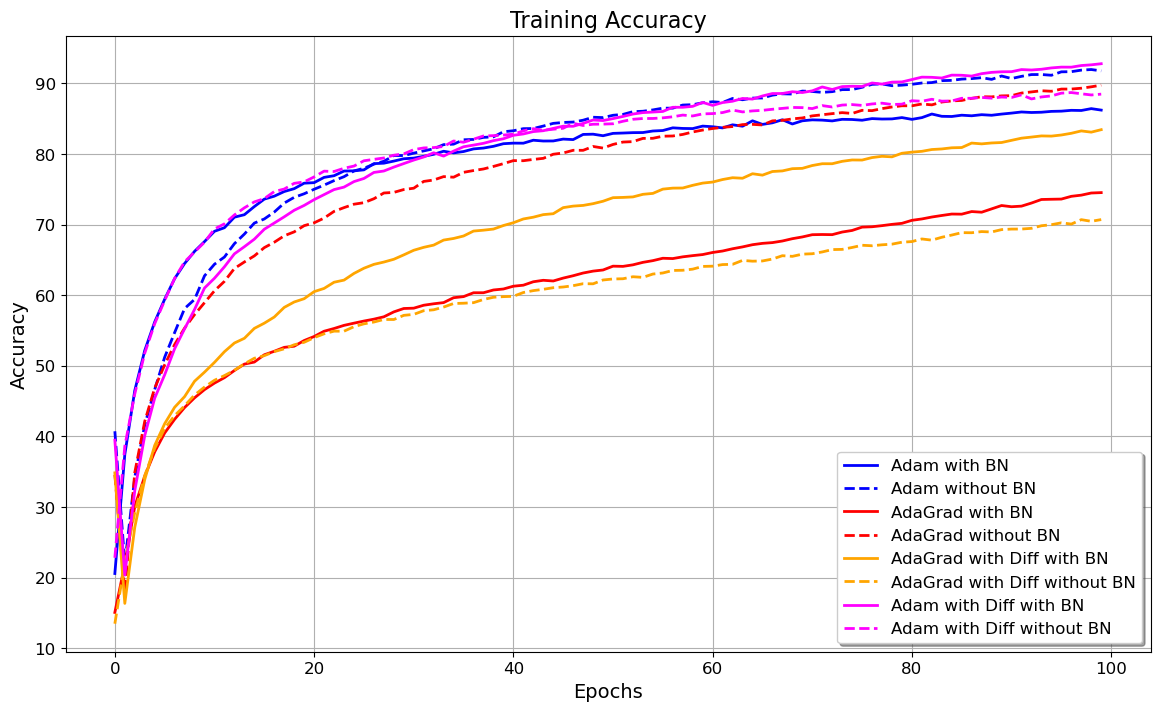

In [26]:
plt.figure(figsize=(14, 8))

# Plotting with improved styles
plt.plot(train_acc_adam_w_bn, label='Adam with BN', color=COLOR_adam, linewidth=LINEWIDTH)
plt.plot(train_acc_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_acc_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada, linewidth=LINEWIDTH)
plt.plot(train_acc_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_acc_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff, linewidth=LINEWIDTH)
plt.plot(train_acc_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(train_acc_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff, linewidth=LINEWIDTH)
plt.plot(train_acc_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed', linewidth=LINEWIDTH)

# Adding grid, labels, and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training Accuracy', fontsize=16)
plt.grid(True)

# Improving legend
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)

# Adding tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./figures/train-accuracies.png', bbox_inches='tight')


#### Validation loss

In [12]:
#Validation Losses
val_loss_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_val_losses.npy")
val_loss_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_val_losses.npy")
val_loss_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_val_losses.npy")
val_loss_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_val_losses.npy")

val_loss_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_val_losses.npy")
val_loss_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_val_losses.npy")
val_loss_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_val_losses.npy")
val_loss_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_val_losses.npy")

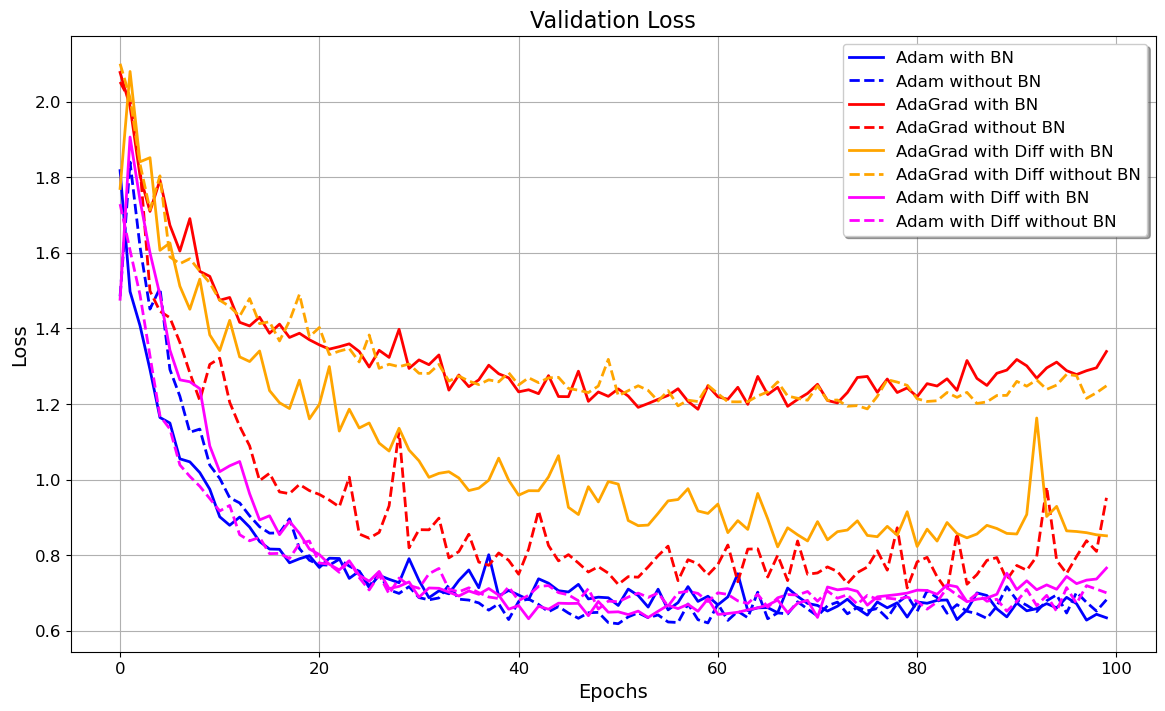

In [27]:
LINEWIDTH = 2

plt.figure(figsize=(14, 8))

# Plotting with improved styles
plt.plot(val_loss_adam_w_bn, label='Adam with BN', color=COLOR_adam, linewidth=LINEWIDTH)
plt.plot(val_loss_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_loss_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada, linewidth=LINEWIDTH)
plt.plot(val_loss_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_loss_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff, linewidth=LINEWIDTH)
plt.plot(val_loss_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_loss_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff, linewidth=LINEWIDTH)
plt.plot(val_loss_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed', linewidth=LINEWIDTH)

# Adding grid, labels, and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Validation Loss', fontsize=16)
plt.grid(True)

# Improving legend
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)

# Adding tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./figures/val-losses.png', bbox_inches='tight')


#### Validation Accuracies

In [28]:
#validation accuracies
val_acc_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_val_accuracies.npy")
val_acc_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_val_accuracies.npy")
val_acc_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_val_accuracies.npy")
val_acc_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_val_accuracies.npy")

val_acc_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_val_accuracies.npy")
val_acc_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_val_accuracies.npy")
val_acc_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_val_accuracies.npy")
val_acc_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_val_accuracies.npy")


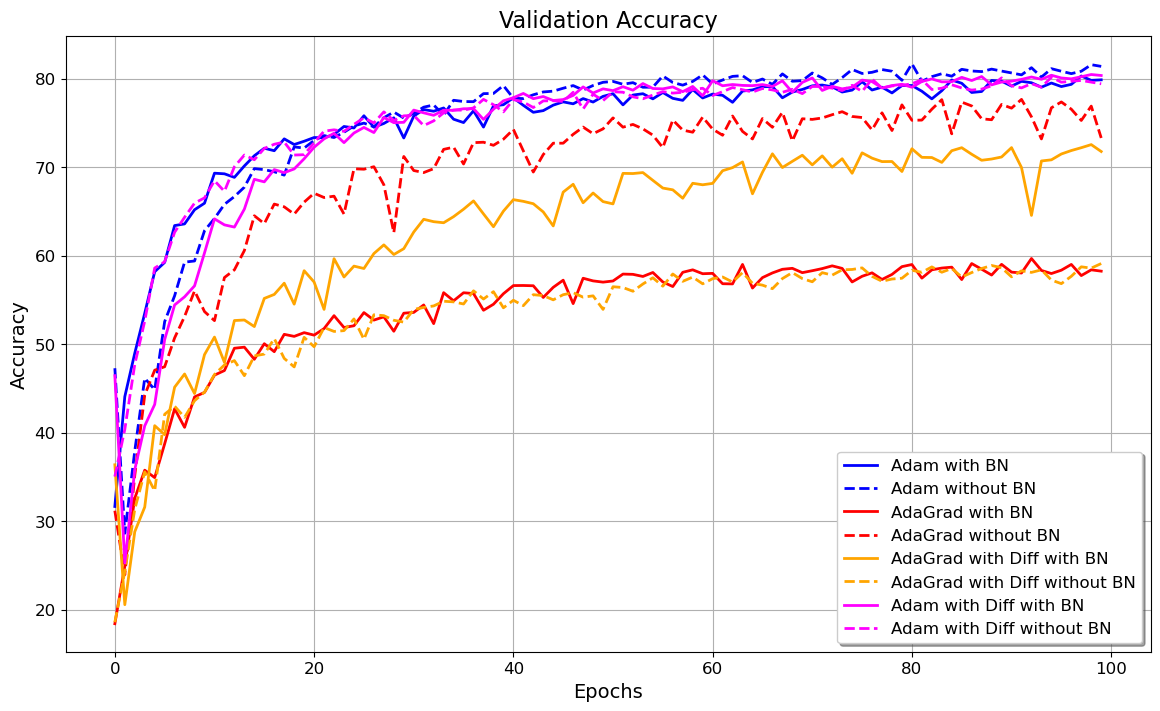

In [31]:
LINEWIDTH = 2

plt.figure(figsize=(14, 8))

# Plotting with improved styles
plt.plot(val_acc_adam_w_bn, label='Adam with BN', color=COLOR_adam, linewidth=LINEWIDTH)
plt.plot(val_acc_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_acc_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada, linewidth=LINEWIDTH)
plt.plot(val_acc_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_acc_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff, linewidth=LINEWIDTH)
plt.plot(val_acc_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed', linewidth=LINEWIDTH)

plt.plot(val_acc_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff, linewidth=LINEWIDTH)
plt.plot(val_acc_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed', linewidth=LINEWIDTH)

# Adding grid, labels, and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Validation Accuracy', fontsize=16)
plt.grid(True)

# Improving legend
plt.legend(loc='best', fontsize=12, frameon=True, shadow=True)

# Adding tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./figures/val-accuracies.png', bbox_inches='tight')

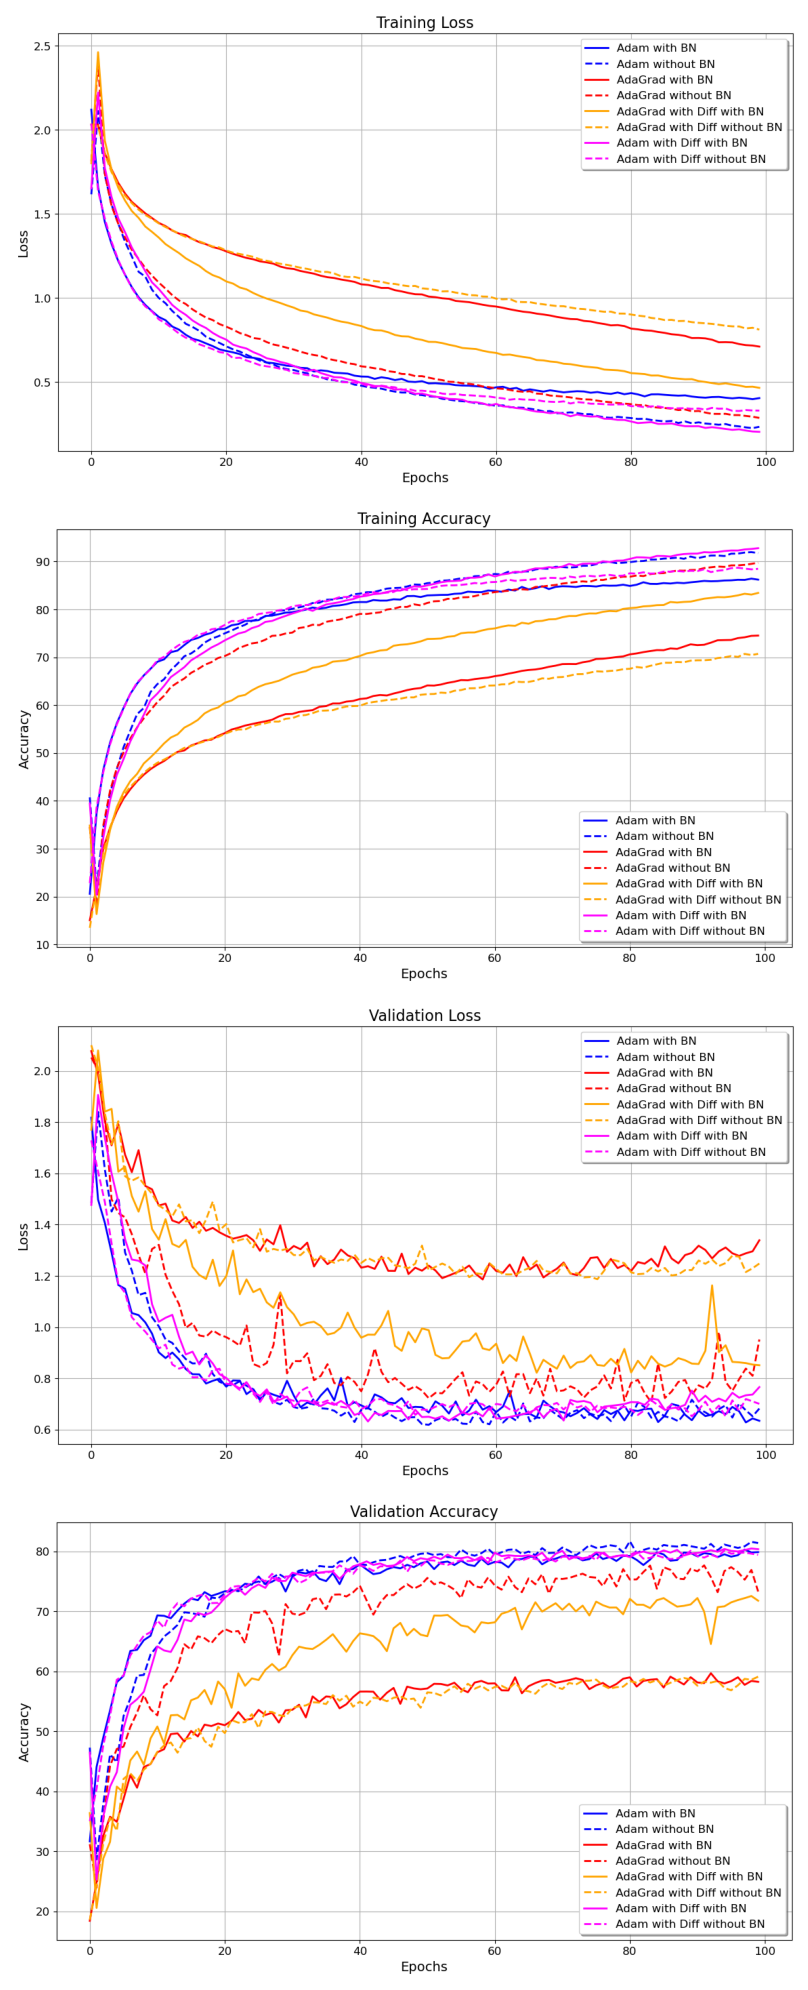

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img1 = mpimg.imread('./figures/train-losses.png')
img2 = mpimg.imread('./figures/train-accuracies.png')
img3 = mpimg.imread('./figures/val-losses.png')
img4 = mpimg.imread('./figures/val-accuracies.png')

fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Display images
axes[0].imshow(img1)
axes[0].axis('off')  # Hide axes
# axes[0].set_title('Image 1')  # Optionally set a title

axes[1].imshow(img2)
axes[1].axis('off')
# axes[1].set_title('Image 2')

axes[2].imshow(img3)
axes[2].axis('off')
# axes[2].set_title('Image 3')

axes[3].imshow(img4)
axes[3].axis('off')
# axes[3].set_title('Image 4')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('./figures/combined_images_vertical.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [37]:
# Final training loss print
print('Final Training Losses:')
print('Adam with BN:', train_loss_adam_w_bn[-1])
print('Adam without BN:', train_loss_adam_wo_bn[-1])
print('AdaGrad with BN:', train_loss_ada_w_bn[-1])
print('AdaGrad without BN:', train_loss_ada_wo_bn[-1])
print('AdaGrad with Diff with BN:', train_loss_adagrad_w_diff_w_bn[-1])
print('AdaGrad with Diff without BN:', train_loss_adagrad_w_diff_wo_bn[-1])
print('Adam with Diff with BN:', train_loss_adam_w_diff_w_bn[-1])
print('Adam with Diff without BN:', train_loss_adam_w_diff_wo_bn[-1])

# Final training accuracy print
print('Final Training Accuracies:')
print('Adam with BN:', train_acc_adam_w_bn[-1])
print('Adam without BN:', train_acc_adam_wo_bn[-1])
print('AdaGrad with BN:', train_acc_ada_w_bn[-1])
print('AdaGrad without BN:', train_acc_ada_wo_bn[-1])

print('AdaGrad with Diff with BN:', train_acc_adagrad_w_diff_w_bn[-1])
print('AdaGrad with Diff without BN:', train_acc_adagrad_w_diff_wo_bn[-1])
print('Adam with Diff with BN:', train_acc_adam_w_diff_w_bn[-1])
print('Adam with Diff without BN:', train_acc_adam_w_diff_wo_bn[-1])



Final Training Losses:
Adam with BN: 0.4040836518516346
Adam without BN: 0.23356201819011144
AdaGrad with BN: 0.7103707513638905
AdaGrad without BN: 0.28637372603525924
AdaGrad with Diff with BN: 0.464963433389761
AdaGrad with Diff without BN: 0.8112557150271474
Adam with Diff with BN: 0.20352670208227877
Adam with Diff without BN: 0.32980178752724004
Final Training Accuracies:
Adam with BN: 86.222
Adam without BN: 91.778
AdaGrad with BN: 74.532
AdaGrad without BN: 89.758
AdaGrad with Diff with BN: 83.448
AdaGrad with Diff without BN: 70.71
Adam with Diff with BN: 92.792
Adam with Diff without BN: 88.482


In [38]:

# Final validation loss print
print('Final Validation Losses:')
print('Adam with BN:', val_loss_adam_w_bn[-1])
print('Adam without BN:', val_loss_adam_wo_bn[-1])
print('AdaGrad with BN:', val_loss_ada_w_bn[-1])
print('AdaGrad without BN:', val_loss_ada_wo_bn[-1])
print('AdaGrad with Diff with BN:', val_loss_adagrad_w_diff_w_bn[-1])
print('AdaGrad with Diff without BN:', val_loss_adagrad_w_diff_wo_bn[-1])
print('Adam with Diff with BN:', val_loss_adam_w_diff_w_bn[-1])
print('Adam with Diff without BN:', val_loss_adam_w_diff_wo_bn[-1])

# Final validation accuracy print
print('Final Validation Accuracies:')
print('Adam with BN:', val_acc_adam_w_bn[-1])
print('Adam without BN:', val_acc_adam_wo_bn[-1])
print('AdaGrad with BN:', val_acc_ada_w_bn[-1])
print('AdaGrad without BN:', val_acc_ada_wo_bn[-1])
print('AdaGrad with Diff with BN:', val_acc_adagrad_w_diff_w_bn[-1])
print('AdaGrad with Diff without BN:', val_acc_adagrad_w_diff_wo_bn[-1])
print('Adam with Diff with BN:', val_acc_adam_w_diff_w_bn[-1])
print('Adam with Diff without BN:', val_acc_adam_w_diff_wo_bn[-1])



Final Validation Losses:
Adam with BN: 0.6341953963041306
Adam without BN: 0.6819479010999203
AdaGrad with BN: 1.3390028148889541
AdaGrad without BN: 0.9517238788306713
AdaGrad with Diff with BN: 0.8511467188596725
AdaGrad with Diff without BN: 1.248161569237709
Adam with Diff with BN: 0.765812560915947
Adam with Diff without BN: 0.7003735721111297
Final Validation Accuracies:
Adam with BN: 79.87
Adam without BN: 81.39
AdaGrad with BN: 58.25
AdaGrad without BN: 73.3
AdaGrad with Diff with BN: 71.77
AdaGrad with Diff without BN: 59.11
Adam with Diff with BN: 80.36
Adam with Diff without BN: 79.42
